## Enhanced layout analysis using suraya Text Detector

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from surya.foundation import FoundationPredictor
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import torch
from pdf2image import convert_from_path
import os
import io
import gc
from PIL import Image
import cv2
import numpy as np
import torch
from transformers import AutoProcessor,Qwen2VLForConditionalGeneration
from PIL import Image
from pdf2image import convert_from_path
from PIL import Image
import os
from tqdm import tqdm
import json
from jiwer import wer, cer, process_words
import re

/Users/maryamsaad/Documents/educational_rag_system/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = "mps" if torch.backends.mps.is_available() else "cpu"

## Reading pdf

In [3]:
def pdf_to_images(path, dpi=300):
    images = []
    if os.path.isfile(path):
        images.extend(convert_from_path(path, dpi=dpi))
    else:
        for pdf_file in tqdm(os.listdir(path), desc="Converting PDFs"):
            if pdf_file.lower().endswith('.pdf'):
                pdf_path = os.path.join(path, pdf_file)
                images.extend(convert_from_path(pdf_path, dpi=dpi))
    print(f"\n✅ Conversion complete!")
    return images

pages = pdf_to_images("/Users/maryamsaad/Documents/grad_data/test_new.pdf")



✅ Conversion complete!


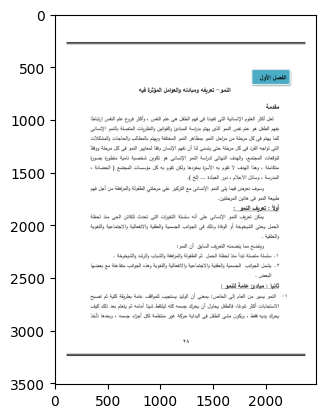

In [4]:
plt.imshow(pages[0])

## loading model and visualization

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


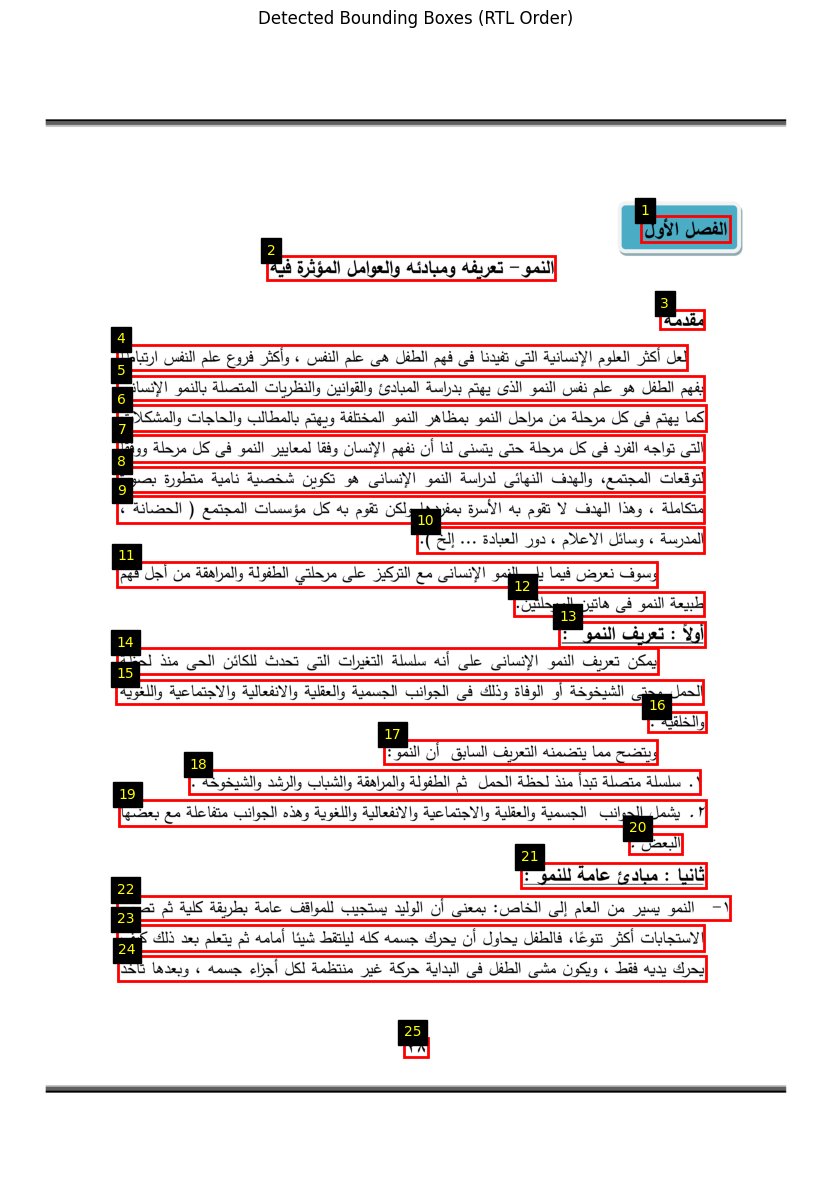

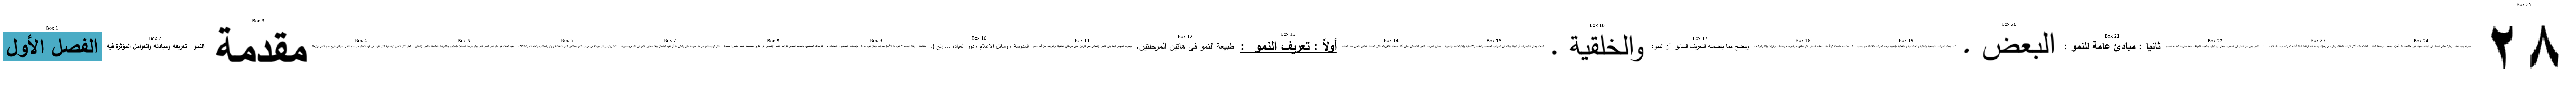

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]]


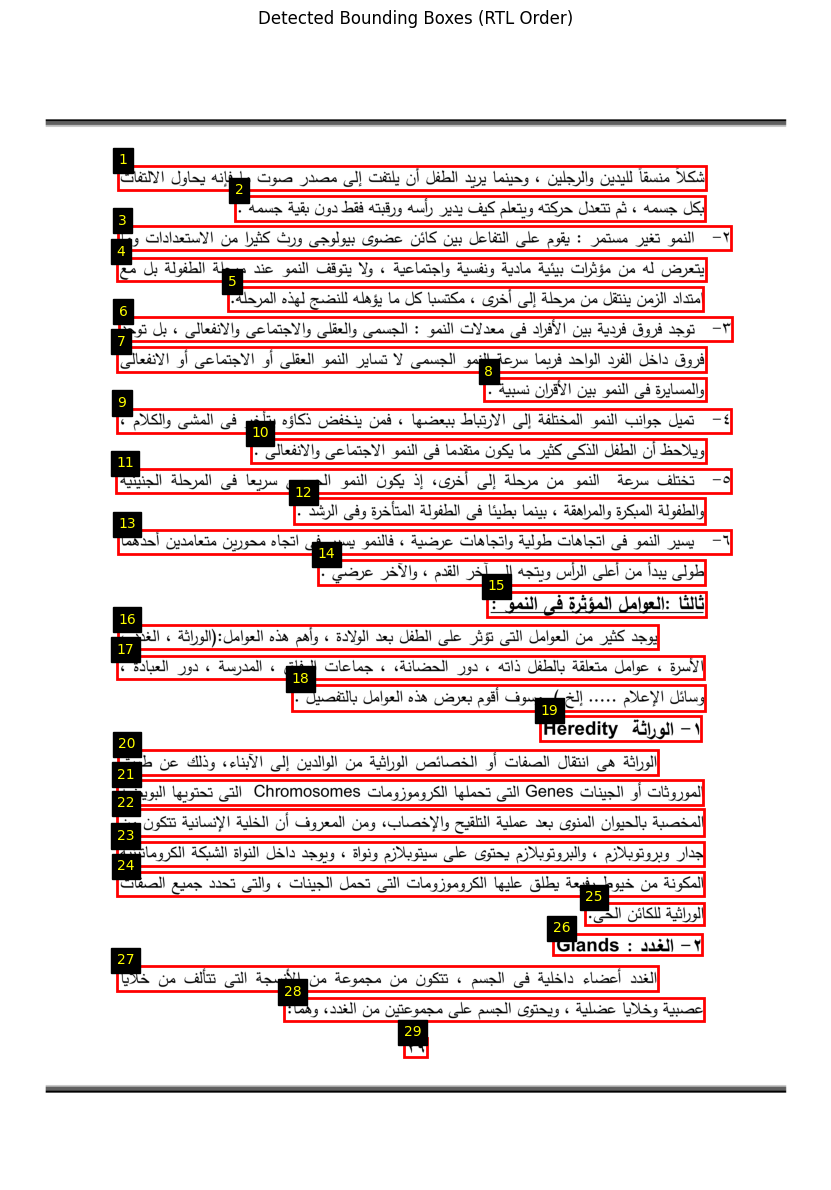

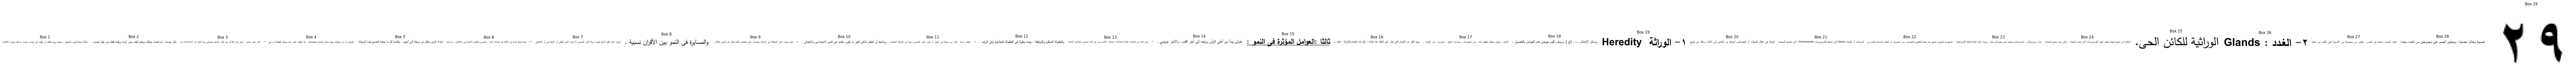

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]]


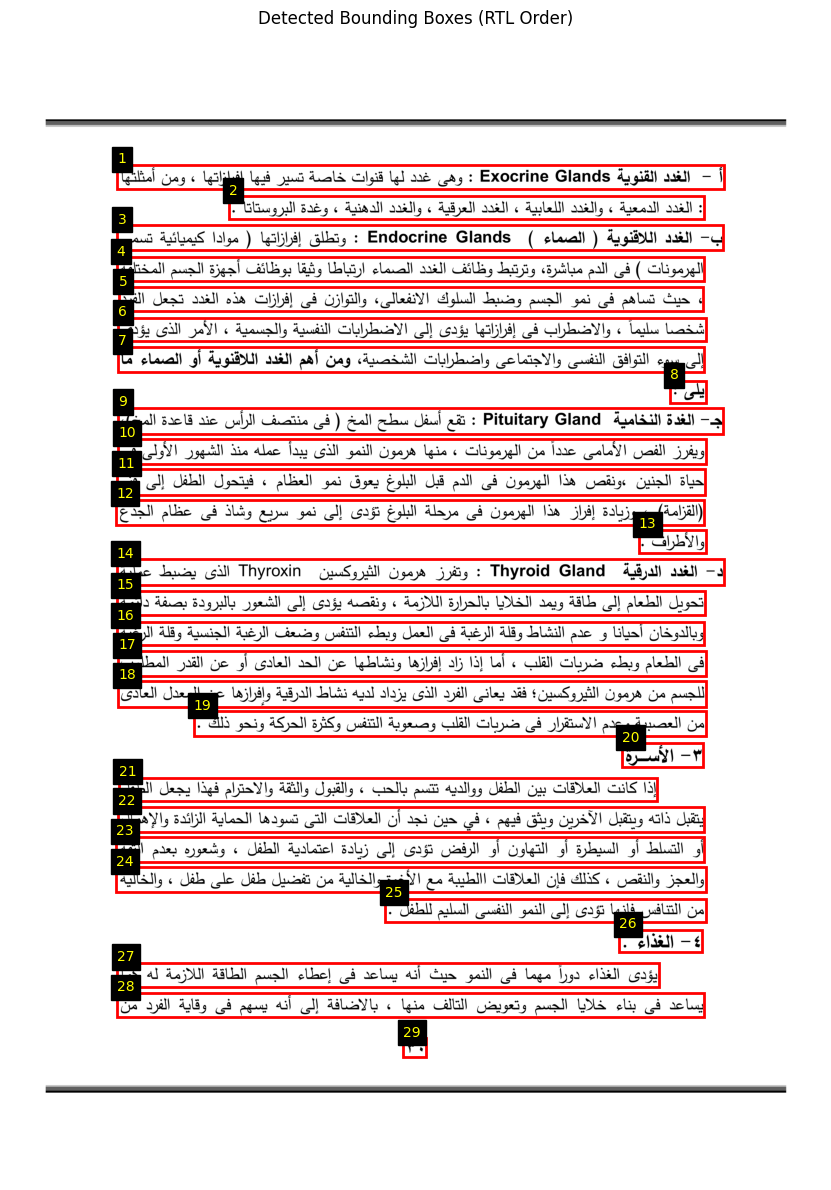

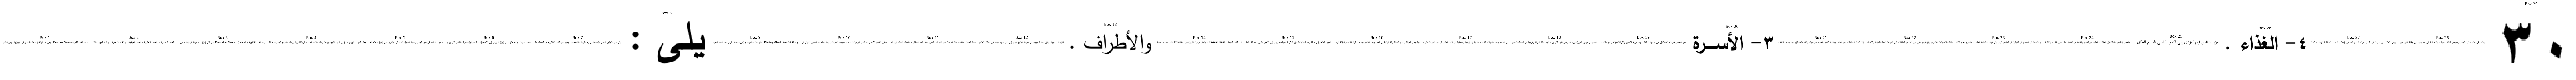

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]]


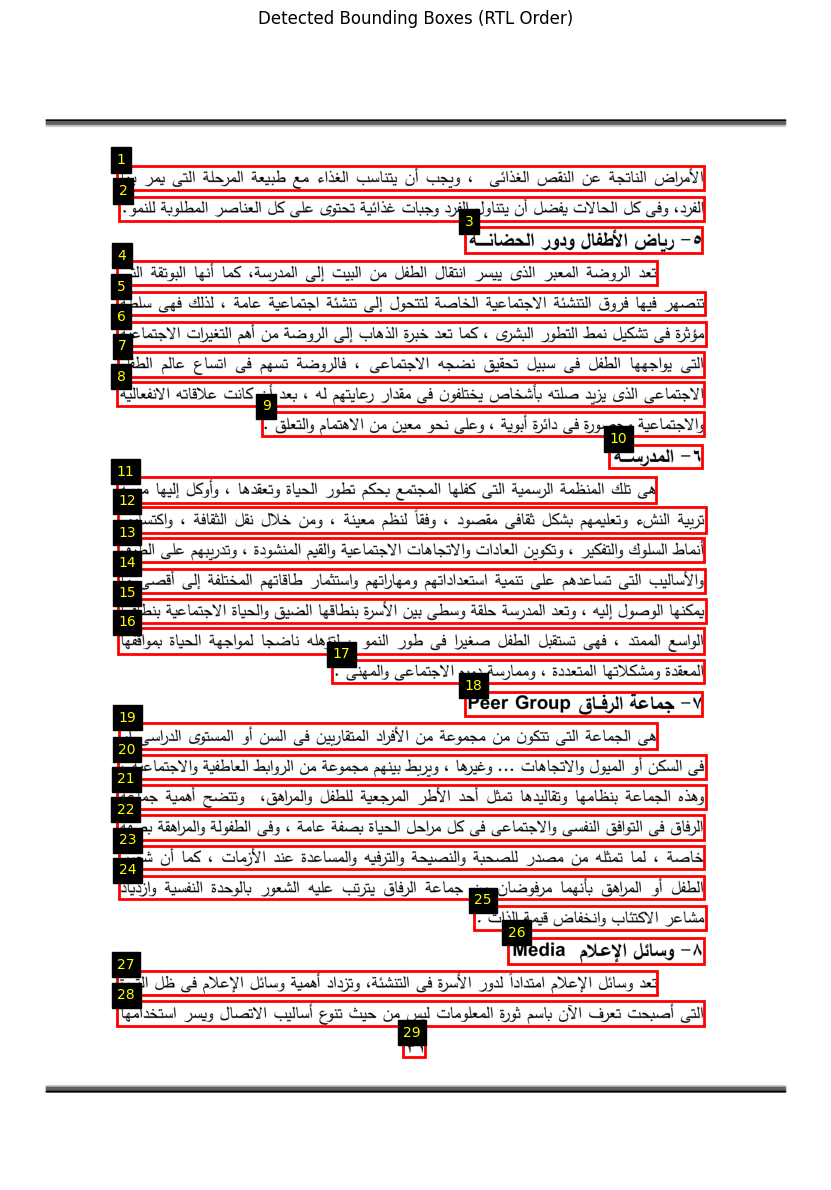

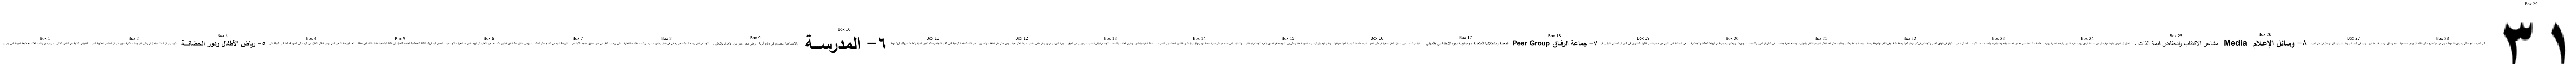

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]]


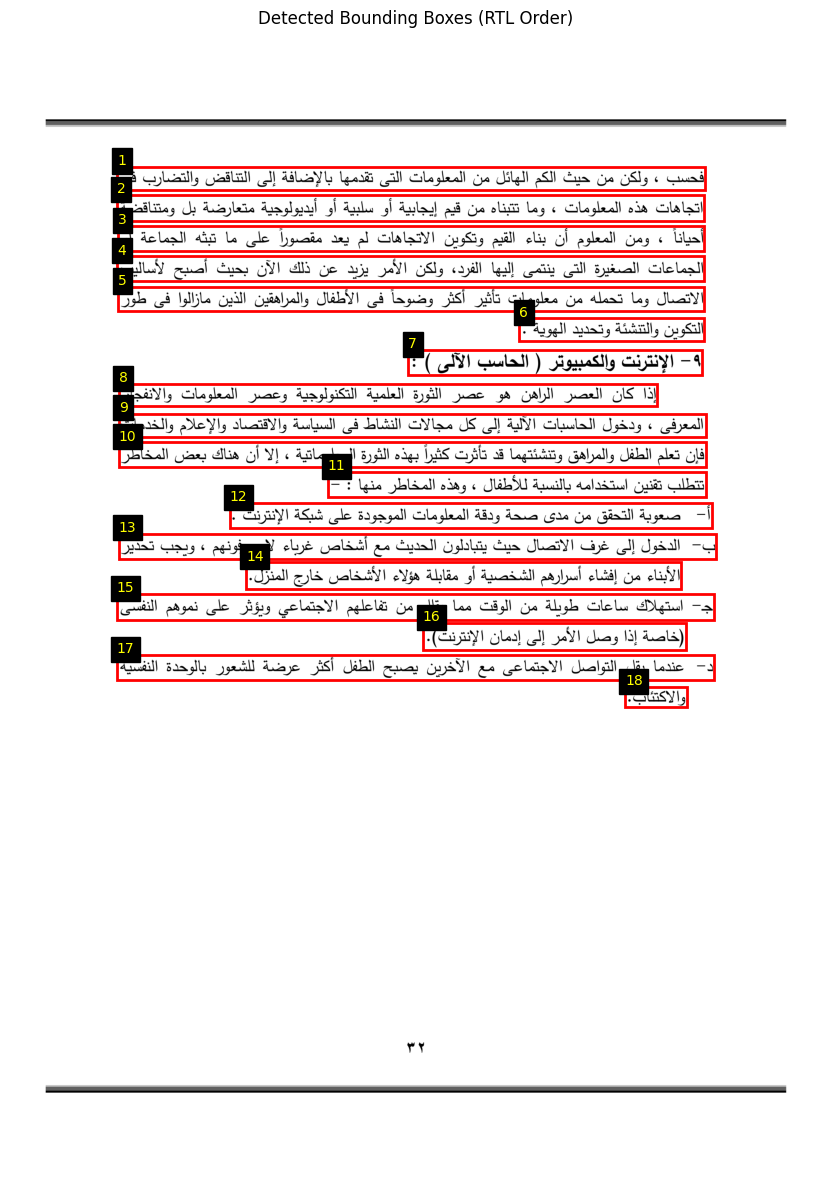

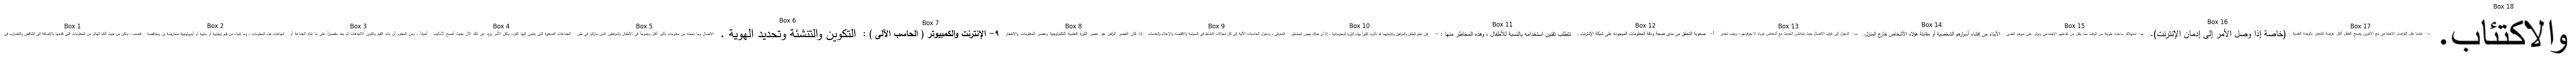

Processing Images: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


In [5]:
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65
PADDING_Y = 10 

for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]
    det_result.bboxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, bbox in enumerate(det_result.bboxes):
        x1, y1, x2, y2 = map(int, bbox.bbox)

        # === expand bounding box vertically ===
        y1 = max(0, y1 - PADDING_Y)
        y2 = min(image.height, y2 + PADDING_Y)

        # draw expanded rectangle
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{i+1}", color="yellow", fontsize=10, backgroundcolor="black")

    plt.title("Detected Bounding Boxes (RTL Order)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # === crop using expanded boxes ===
    cropped_images = []
    for bbox in det_result.bboxes:
        x1, y1, x2, y2 = map(int, bbox.bbox)
        y1 = max(0, y1 - PADDING_Y)
        y2 = min(image.height, y2 + PADDING_Y)
        cropped_region = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_region)

    if cropped_images:
        n = len(cropped_images)
        fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
        if n == 1:
            axs = [axs]
        for i, crop in enumerate(cropped_images):
            axs[i].imshow(crop)
            axs[i].set_title(f"Box {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()


## Extracting text boxes

In [6]:

print(pages)
print(type(pages))

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x318500050>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x3183E5E50>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x3183E5F90>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x3183F0FC0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x3183F1220>]
<class 'list'>


Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


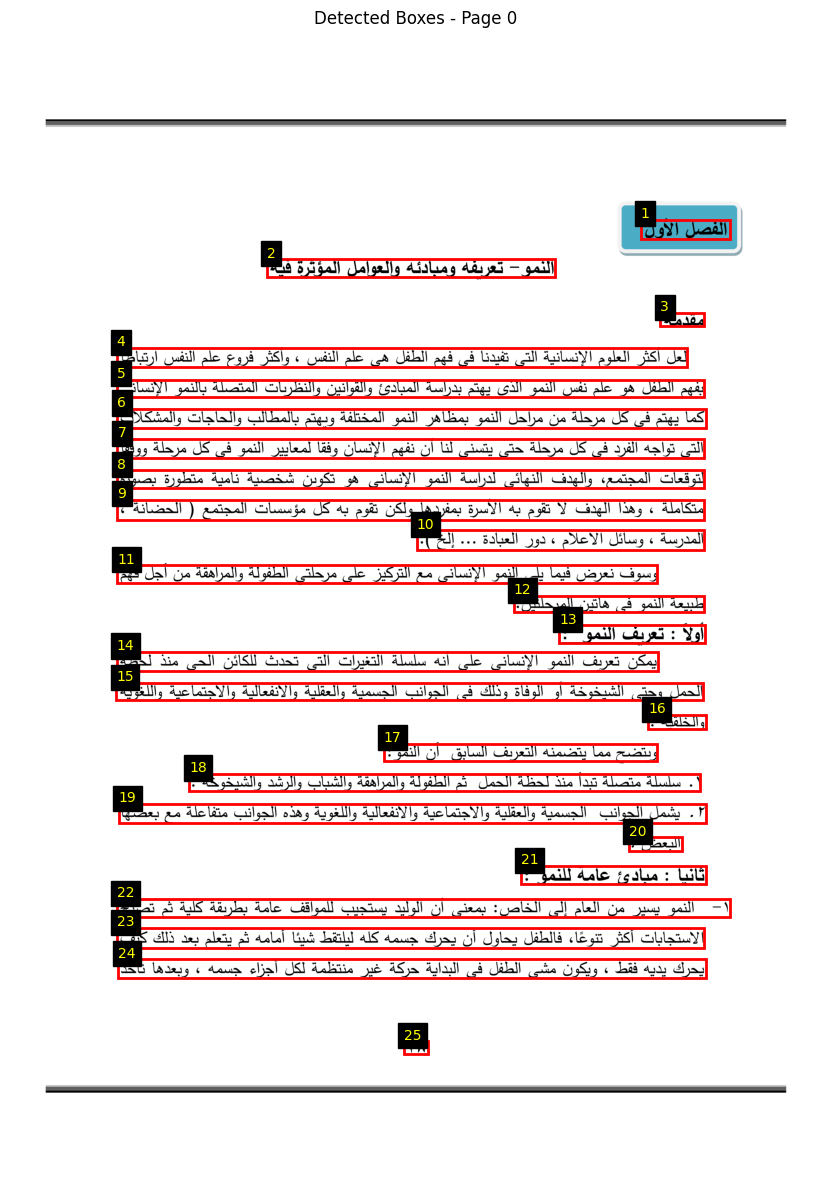

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]]


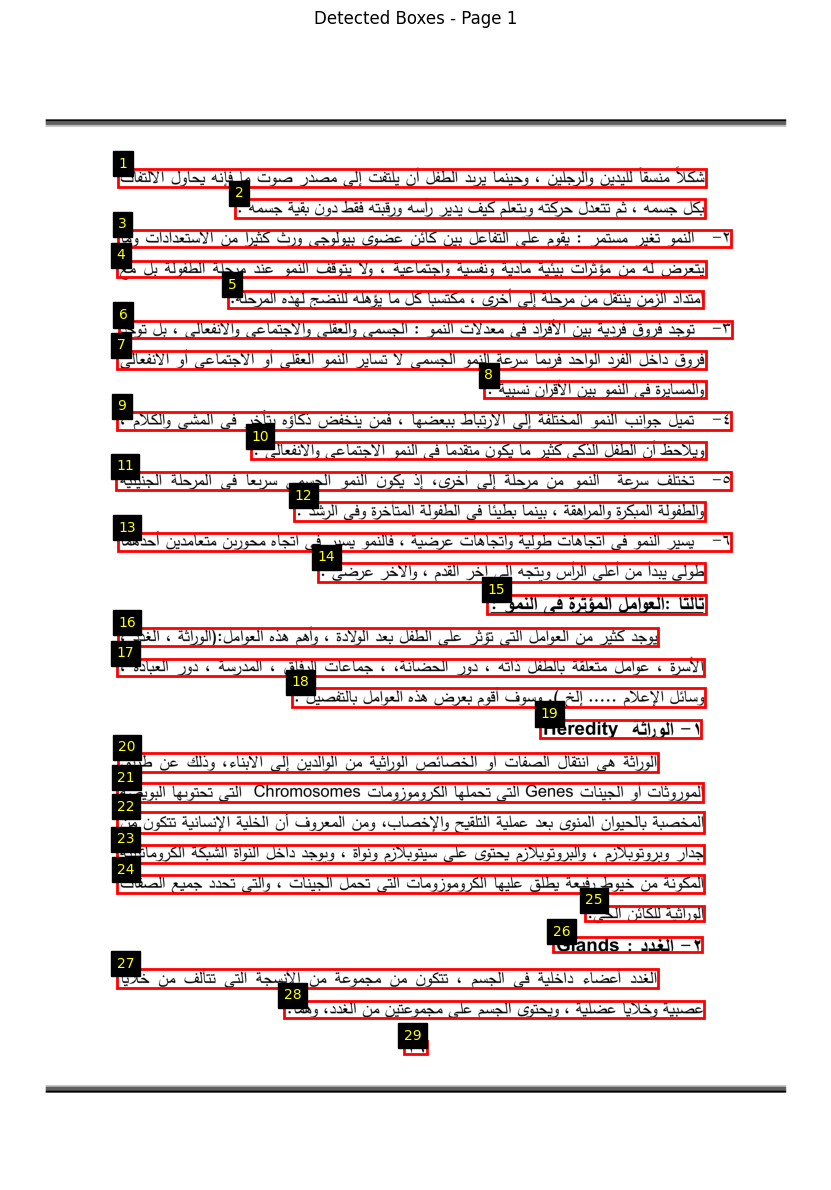

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]]


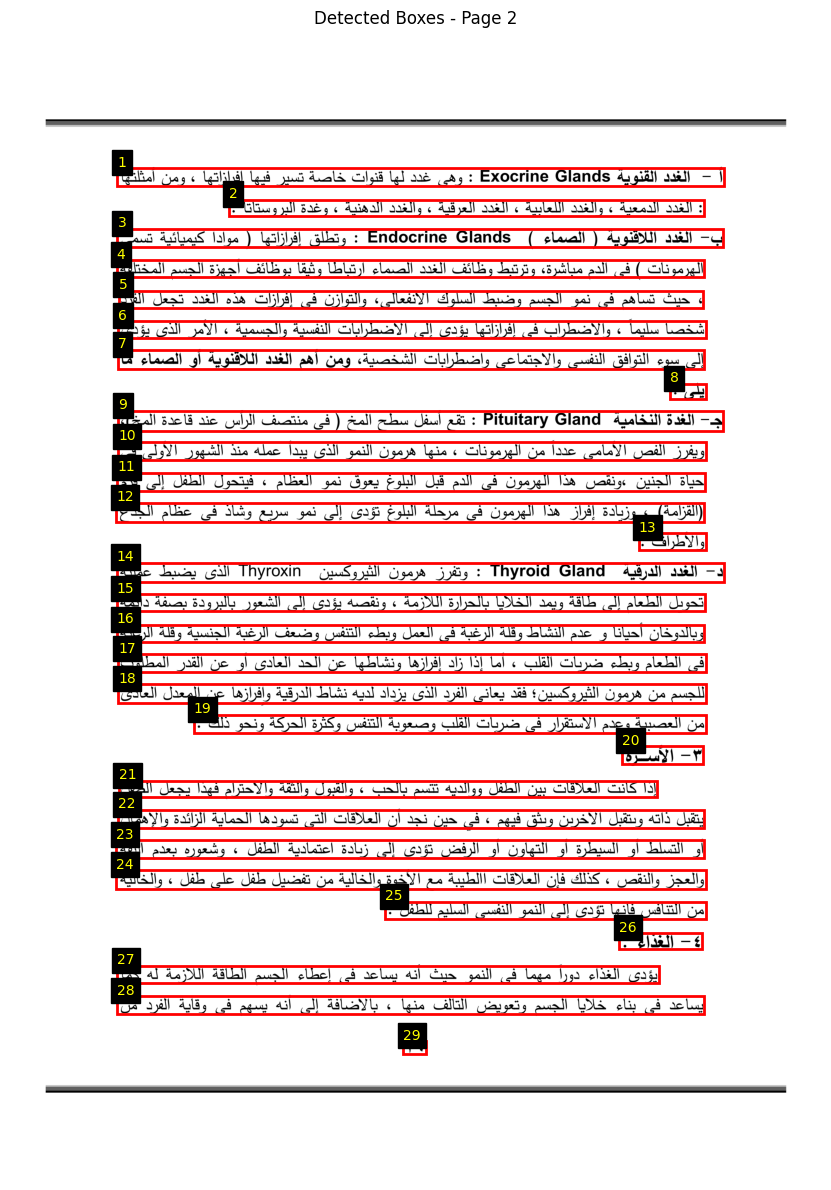

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]]


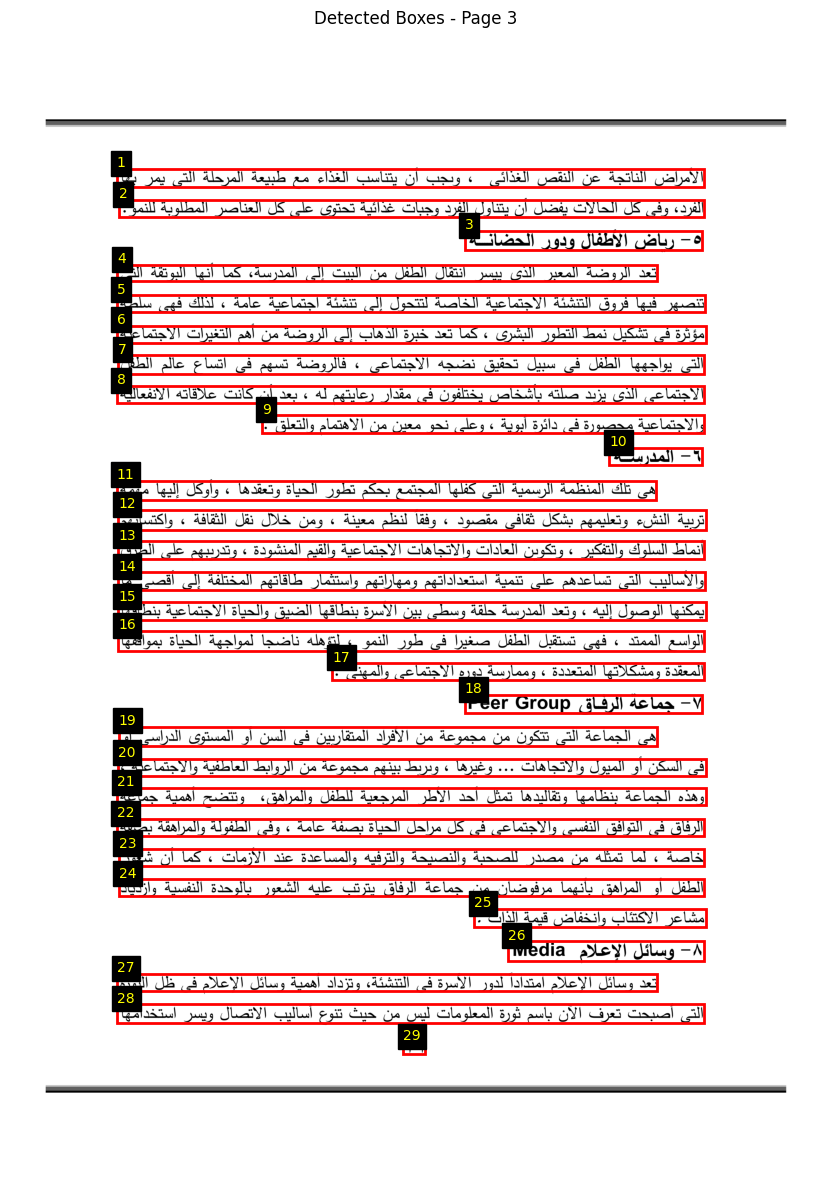

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]]


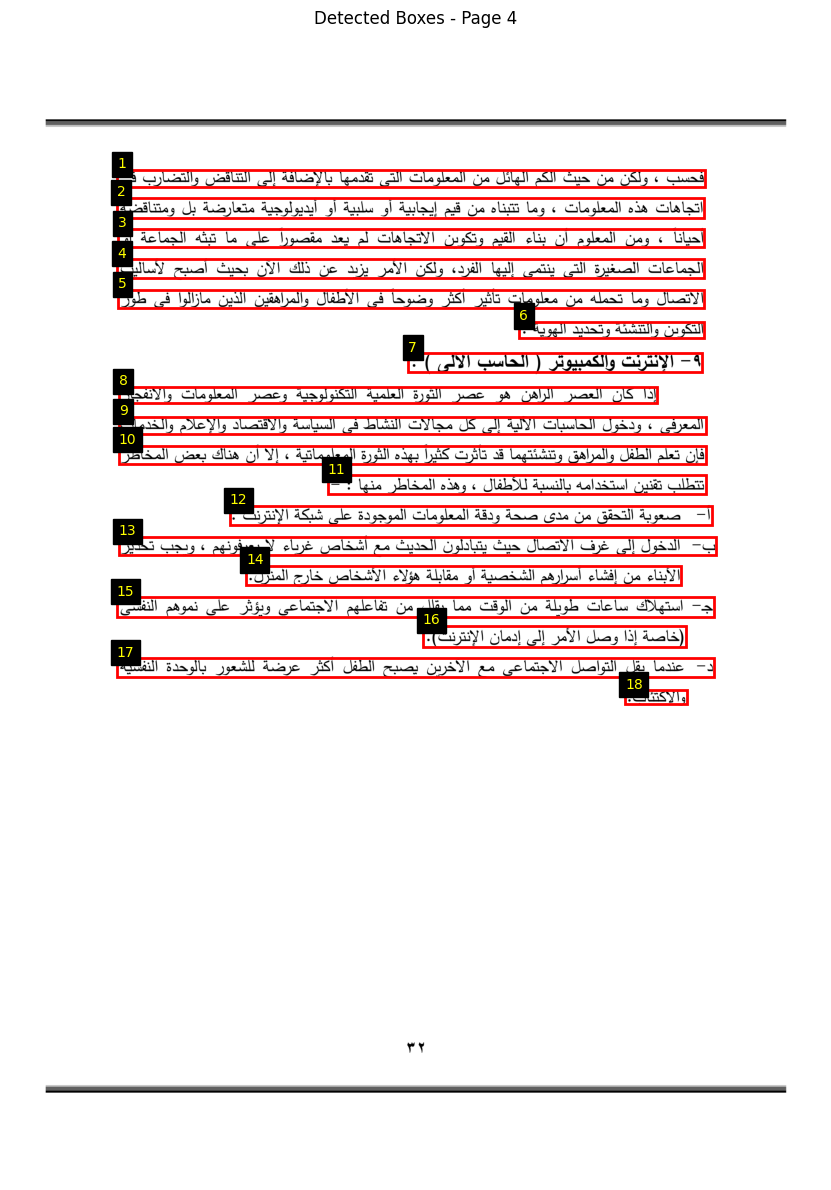

Processing Images: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


In [11]:
book_pages = {}

foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65
PADDING_Y = 20 

for idx, image in enumerate(tqdm(pages, desc="Processing Images")):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter bounding boxes by confidence
    det_result.bboxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Crop regions
    cropped_images = []
    for bbox in det_result.bboxes:
        x1, y1, x2, y2 = map(int, bbox.bbox)
    #=== expand bounding box vertically ===
        y1 = max(0, y1 - PADDING_Y)
        y2 = min(image.height, y2 + PADDING_Y)
        cropped_region = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_region)

    # ✅ Store cropped images for this page index
    book_pages[idx] = cropped_images

    # Optional visualization
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)
    for i, bbox in enumerate(det_result.bboxes):
        x1, y1, x2, y2 = map(int, bbox.bbox)
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{i+1}", color="yellow", fontsize=10, backgroundcolor="black")

    plt.title(f"Detected Boxes - Page {idx}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [12]:
book_pages

{0: [<PIL.Image.Image image mode=RGB size=273x100>,
  <PIL.Image.Image image mode=RGB size=880x94>,
  <PIL.Image.Image image mode=RGB size=134x80>,
  <PIL.Image.Image image mode=RGB size=1744x97>,
  <PIL.Image.Image image mode=RGB size=1796x94>,
  <PIL.Image.Image image mode=RGB size=1799x98>,
  <PIL.Image.Image image mode=RGB size=1792x100>,
  <PIL.Image.Image image mode=RGB size=1794x95>,
  <PIL.Image.Image image mode=RGB size=1792x102>,
  <PIL.Image.Image image mode=RGB size=877x99>,
  <PIL.Image.Image image mode=RGB size=1651x95>,
  <PIL.Image.Image image mode=RGB size=583x91>,
  <PIL.Image.Image image mode=RGB size=446x95>,
  <PIL.Image.Image image mode=RGB size=1654x98>,
  <PIL.Image.Image image mode=RGB size=1794x93>,
  <PIL.Image.Image image mode=RGB size=176x82>,
  <PIL.Image.Image image mode=RGB size=837x92>,
  <PIL.Image.Image image mode=RGB size=1563x93>,
  <PIL.Image.Image image mode=RGB size=1795x99>,
  <PIL.Image.Image image mode=RGB size=163x81>,
  <PIL.Image.Image imag

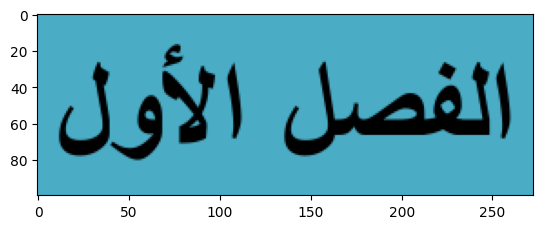

In [13]:
plt.imshow(book_pages[0][0])


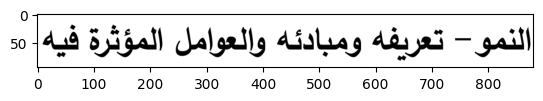

In [14]:
plt.imshow(book_pages[0][1])

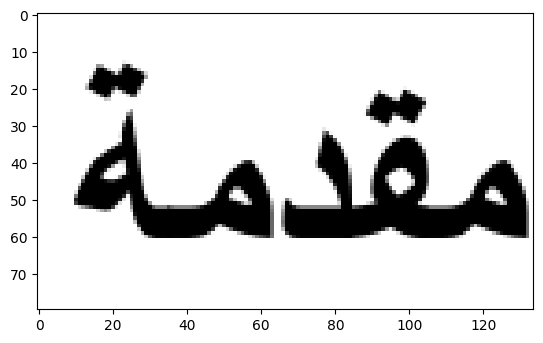

In [15]:
plt.imshow(book_pages[0][2])

## Image Preprocessing

In [17]:
sample=book_pages[0][2]
sample = np.array(sample)



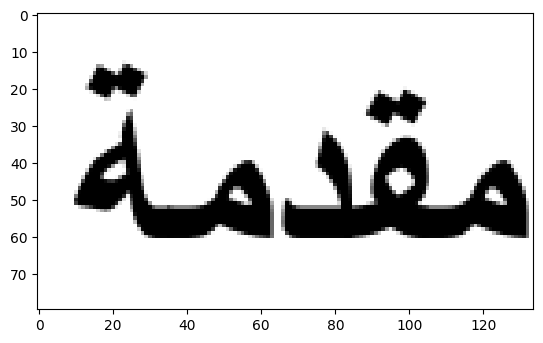

In [18]:
gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

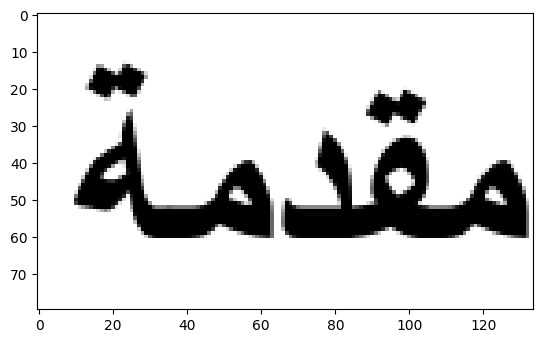

In [19]:
denoised = cv2.fastNlMeansDenoising(gray, h=10)
plt.imshow(denoised, cmap='gray')

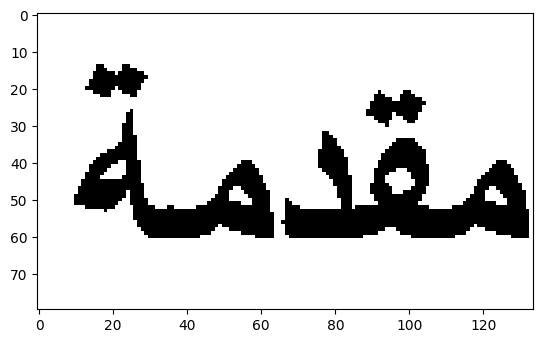

In [20]:
binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
plt.imshow(binary, cmap='gray')

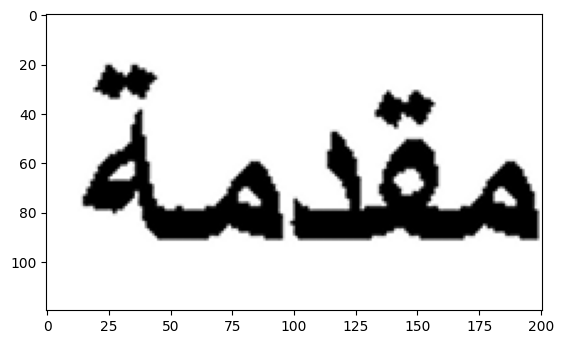

In [21]:
target_height = 120
scale = target_height / binary.shape[0]
resized = cv2.resize(binary, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
plt.imshow(resized, cmap='gray')

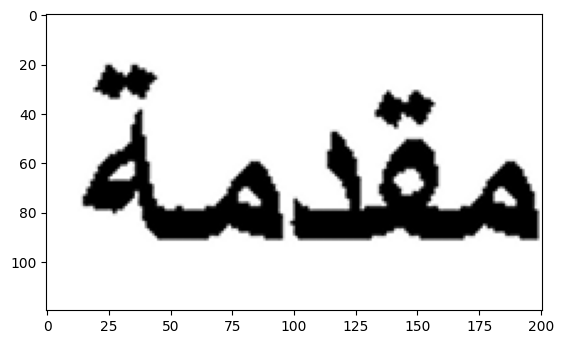

In [22]:
kernel = np.ones((1, 1), np.uint8)
processed = cv2.dilate(resized, kernel, iterations=1)
plt.imshow(processed, cmap='gray')

In [23]:
def preprocess_image(image):
    sample = np.array(image)
    gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, h=10)
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    target_height = 120
    scale = target_height / binary.shape[0]
    resized = cv2.resize(binary, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    kernel = np.ones((1, 1), np.uint8)
    processed = cv2.dilate(resized, kernel, iterations=1)
    return processed


preprocessed_book_pages = {}
for page_idx in sorted(book_pages.keys()):
    textboxes = book_pages[page_idx]
    preprocessed_book_pages[page_idx] = [preprocess_image(tb) for tb in textboxes]


In [24]:
preprocessed_book_pages.keys()

dict_keys([0, 1, 2, 3, 4])

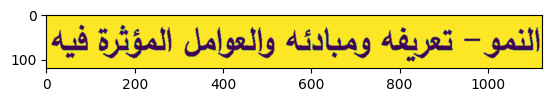

In [25]:
plt.imshow(preprocessed_book_pages[0][1])

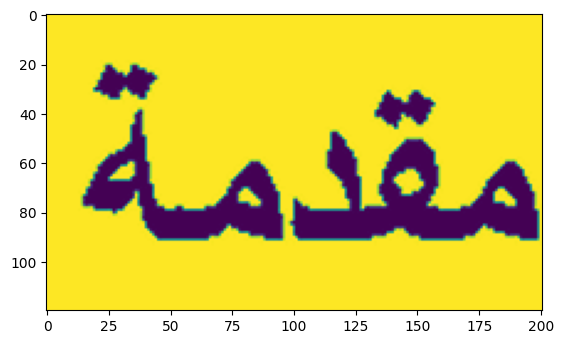

In [26]:
plt.imshow(preprocessed_book_pages[0][2])

## Passing artifacts to next module

#### Loading OCR

In [27]:

model_id = "NAMAA-Space/Qari-OCR-v0.3-VL-2B-Instruct"
processor_id = "Qwen/Qwen2-VL-2B-Instruct"

# Use CPU for now (MPS has memory issues with large vision models)
device = torch.device("mps")
print(device)

# Load model with float32 for CPU
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16, 
    trust_remote_code=True,
    cache_dir="./Qari_model_cache"
).to(device)

# Load processor
processor = AutoProcessor.from_pretrained(
    processor_id,
    trust_remote_code=True,
    cache_dir="./Qwen_processor_cache"
)
tokenizer = processor.tokenizer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
eos_id = tokenizer.eos_token_id
pad_id = tokenizer.pad_token_id
noise_strings = [
    "br","<br>","</br>","p","<p>","</p>","div","<div>","</div>","span","<span>","</span>",
    "document","pdivdocument","hbrh","ipbrh","ipbrp",
    "bold","italic","underline","http","https",
    # frequent English bleed
    "Global","Trends","The","To","Brown","Cities"
]
bad_words_ids = []
for s in noise_strings:
    ids = tokenizer(s, add_special_tokens=False).input_ids
    if ids:
        bad_words_ids.append(ids)
print(f"✅ Model ready on {device}")


`torch_dtype` is deprecated! Use `dtype` instead!


mps


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


✅ Model ready on mps


In [28]:
def get_ocr_prompt() -> str:
    """Get the OCR instruction prompt for Arabic text."""
    return """
        You are an Arabic OCR specialist designed to extract text from images containing Arabic content. When processing images:
        1. ALWAYS read Arabic text from right to left, and top to bottom.
        3. DO NOT hallucinate text when encountering:
           - Decorative elements
           - Page numbers, stamps, or margin notes
           - Blurry or unclear text
        4. When text is unclear, mark it as [غير واضح].
        5. Only transcribe visible text — accuracy > completeness.
        6. Ignore watermarks and non-text background elements.
        8. Preserve original formatting, including line breaks and spacing.
        9. Do not hallucinate punctuation or diacritics. 
        10. Output the extracted text as it is visually presented in the image.
        Return the extracted text only.

    """


In [29]:
from tqdm import tqdm

def extract_text_from_image(images, model, processor, max_size=(1024, 1024), show_progress=True):
    ocr_results = []

    iterator = tqdm(images, desc="Extracting text", disable=not show_progress)
    for img in iterator:
        # Resize image if too large
        if img.size[0] > max_size[0] or img.size[1] > max_size[1]:
            img = img.copy()
            img.thumbnail(max_size, Image.Resampling.LANCZOS)

        prompt_messages = [
            {"role": "system", "content": [{"type": "text", "text": get_ocr_prompt()}]},
            {"role": "user", "content": [{"type": "image", "image": img}]},
        ]

        prompt_text = processor.apply_chat_template(
            prompt_messages,
            add_generation_prompt=True,
            tokenize=False,
        )

        inputs = processor(
            text=prompt_text,
            images=img,
            return_tensors="pt",
            padding=True,
        ).to(model.device)

        with torch.inference_mode():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=256,
                do_sample=False,
                temperature=0.0,
                repetition_penalty=1.2,
                no_repeat_ngram_size=6,
                eos_token_id=eos_id,
                pad_token_id=pad_id,
                use_cache=True,
            )

        input_len = int(inputs["attention_mask"].sum().item()) if "attention_mask" in inputs else inputs["input_ids"].shape[-1]
        gen_only = generated_ids[0, input_len:]

        text = processor.decode(
            gen_only,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        ).strip()

        # Cleanup leaked role markers
        if text.lower().startswith(("system", "user", "assistant")):
            import re
            text = re.sub(r"^(system|user|assistant)\s*:?\s*", "", text, flags=re.I).strip()

        ocr_results.append(text)

    return ocr_results


In [30]:
all_ocr_results = {}
for page_idx in tqdm(sorted(preprocessed_book_pages.keys()), desc="OCR pages"):
    textboxes = preprocessed_book_pages[page_idx]
    print(f"Processing page {page_idx}...")
    pil_textboxes = [Image.fromarray(tb) for tb in textboxes]
    ocr_results = extract_text_from_image(pil_textboxes, model, processor, show_progress=False)
    assert len(ocr_results) == len(pil_textboxes), (
        f"OCR count mismatch on page {page_idx}: in={len(pil_textboxes)} out={len(ocr_results)}"
    )
    all_ocr_results[page_idx] = ocr_results
    print(f"✅ Completed OCR for page {page_idx}.")

OCR pages:   0%|          | 0/5 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processing page 0...


OCR pages:  20%|██        | 1/5 [00:38<02:35, 38.90s/it]

✅ Completed OCR for page 0.
Processing page 1...


OCR pages:  40%|████      | 2/5 [01:31<02:20, 46.97s/it]

✅ Completed OCR for page 1.
Processing page 2...


OCR pages:  60%|██████    | 3/5 [02:23<01:38, 49.09s/it]

✅ Completed OCR for page 2.
Processing page 3...


OCR pages:  80%|████████  | 4/5 [03:23<00:53, 53.67s/it]

✅ Completed OCR for page 3.
Processing page 4...


OCR pages: 100%|██████████| 5/5 [03:49<00:00, 45.82s/it]

✅ Completed OCR for page 4.


In [31]:
all_ocr_results

{0: ['الفصل الأول',
  'النمو- تعريفه ومبادئه والعوامل المؤثرة فيه',
  'مقدمة',
  'لفعل <b>أكثر</b> العلوم الإنسانية التي تفيدنا في فهم الطفل هي علم النفس ، وأكثر فروع علم الناس ارتباطا',
  'بفهم الطفل هو علم <b>النمو</b> الذي يهتم بدراسة المبادئ والقوانين والنظريات المتصلة بالنمو الإنساني',
  'كما يهتم <b>فى</b> كل مرحلة من مراحل النمو بمظاهر النمو المختلفة ويهتم بالمطالب والحاجات والمشكلات',
  'التي تواجه الفرد في كل مرحلة حتى يتسنى لنا أن نفهم الإنسان وفقا لمعايير النمو <b>فى</b> كل مرحلة ووفقاً <i>ل...</i>',
  'لتوقعات المجتمع، والهدف النهائي لدراسة النمو الإنساني هو تكوين شخصية نامية متطورة بصورة <b>مباشرة</b>.',
  'هدف لا تتقوم به الأسرة بمفردها ولكن تقوم به كل مؤسسات المجتمع ( الحضانة ، متكاملة <b>،</b> وهذا الهدف لا تتقوم به <i>بالمجتمع</i> <u>(الحضانة)</u> ) .',
  'المدرسة ، وسائل الاعلام <b>،</b> دور العبادة ... إلخ ().',
  'وسوف نعرض فيما يلى النمو الإنساني مع التركيز على مرحلتي الطفلة والمراهقة من أجل فهمه <b>وسوف</b> نعرض فيما يلى <i>النمو</i> <u>الإنسانى</u> مع التركيز على

In [32]:
final_page_texts = {}

for page_idx in sorted(all_ocr_results.keys()):
    ocr_texts = all_ocr_results[page_idx]
    page_text = "\n".join(t.strip() for t in ocr_texts if t.strip())
    final_page_texts[page_idx] = page_text

In [33]:
final_page_texts

{0: 'الفصل الأول\nالنمو- تعريفه ومبادئه والعوامل المؤثرة فيه\nمقدمة\nلفعل <b>أكثر</b> العلوم الإنسانية التي تفيدنا في فهم الطفل هي علم النفس ، وأكثر فروع علم الناس ارتباطا\nبفهم الطفل هو علم <b>النمو</b> الذي يهتم بدراسة المبادئ والقوانين والنظريات المتصلة بالنمو الإنساني\nكما يهتم <b>فى</b> كل مرحلة من مراحل النمو بمظاهر النمو المختلفة ويهتم بالمطالب والحاجات والمشكلات\nالتي تواجه الفرد في كل مرحلة حتى يتسنى لنا أن نفهم الإنسان وفقا لمعايير النمو <b>فى</b> كل مرحلة ووفقاً <i>ل...</i>\nلتوقعات المجتمع، والهدف النهائي لدراسة النمو الإنساني هو تكوين شخصية نامية متطورة بصورة <b>مباشرة</b>.\nهدف لا تتقوم به الأسرة بمفردها ولكن تقوم به كل مؤسسات المجتمع ( الحضانة ، متكاملة <b>،</b> وهذا الهدف لا تتقوم به <i>بالمجتمع</i> <u>(الحضانة)</u> ) .\nالمدرسة ، وسائل الاعلام <b>،</b> دور العبادة ... إلخ ().\nوسوف نعرض فيما يلى النمو الإنساني مع التركيز على مرحلتي الطفلة والمراهقة من أجل فهمه <b>وسوف</b> نعرض فيما يلى <i>النمو</i> <u>الإنسانى</u> مع التركيز على المرحلة <b>الطفلية</b> والمراهقَةِ من أج

In [34]:
from bs4 import BeautifulSoup
import html

def reconstruct_pages(html_content):
    reconstructed_pages = []
    for content in html_content:
        # Decode HTML entities (e.g., &quot;)
        decoded = html.unescape(content)
        # Parse and extract text
        soup = BeautifulSoup(decoded, "html.parser")
        plain_text = soup.get_text(separator="\n")
        # Remove excessive blank lines
        plain_text = "\n".join([line.strip() for line in plain_text.splitlines() if line.strip()])
        reconstructed_pages.append(plain_text)
    return reconstructed_pages

for page_idx in sorted(final_page_texts.keys()):
    text = reconstruct_pages([final_page_texts[page_idx]])[0]
    final_page_texts[page_idx] = text
    print(f"✅ Reconstructed text for page {page_idx}:")
    print(final_page_texts[page_idx])


✅ Reconstructed text for page 0:
الفصل الأول
النمو- تعريفه ومبادئه والعوامل المؤثرة فيه
مقدمة
لفعل
أكثر
العلوم الإنسانية التي تفيدنا في فهم الطفل هي علم النفس ، وأكثر فروع علم الناس ارتباطا
بفهم الطفل هو علم
النمو
الذي يهتم بدراسة المبادئ والقوانين والنظريات المتصلة بالنمو الإنساني
كما يهتم
فى
كل مرحلة من مراحل النمو بمظاهر النمو المختلفة ويهتم بالمطالب والحاجات والمشكلات
التي تواجه الفرد في كل مرحلة حتى يتسنى لنا أن نفهم الإنسان وفقا لمعايير النمو
فى
كل مرحلة ووفقاً
ل...
لتوقعات المجتمع، والهدف النهائي لدراسة النمو الإنساني هو تكوين شخصية نامية متطورة بصورة
مباشرة
.
هدف لا تتقوم به الأسرة بمفردها ولكن تقوم به كل مؤسسات المجتمع ( الحضانة ، متكاملة
،
وهذا الهدف لا تتقوم به
بالمجتمع
(الحضانة)
) .
المدرسة ، وسائل الاعلام
،
دور العبادة ... إلخ ().
وسوف نعرض فيما يلى النمو الإنساني مع التركيز على مرحلتي الطفلة والمراهقة من أجل فهمه
وسوف
نعرض فيما يلى
النمو
الإنسانى
مع التركيز على المرحلة
الطفلية
والمراهقَةِ من أجل فهمه.
طبيعة النمو في
هاتين
المرحلتين .
أولاً :
تعريف
النمو
:
:
يمكن
تعريف
الن

In [35]:
page_order = sorted(final_page_texts.keys())
final_pages_list = [final_page_texts[i] for i in page_order]

In [37]:
final_pages_list

['الفصل الأول\nالنمو- تعريفه ومبادئه والعوامل المؤثرة فيه\nمقدمة\nلفعل\nأكثر\nالعلوم الإنسانية التي تفيدنا في فهم الطفل هي علم النفس ، وأكثر فروع علم الناس ارتباطا\nبفهم الطفل هو علم\nالنمو\nالذي يهتم بدراسة المبادئ والقوانين والنظريات المتصلة بالنمو الإنساني\nكما يهتم\nفى\nكل مرحلة من مراحل النمو بمظاهر النمو المختلفة ويهتم بالمطالب والحاجات والمشكلات\nالتي تواجه الفرد في كل مرحلة حتى يتسنى لنا أن نفهم الإنسان وفقا لمعايير النمو\nفى\nكل مرحلة ووفقاً\nل...\nلتوقعات المجتمع، والهدف النهائي لدراسة النمو الإنساني هو تكوين شخصية نامية متطورة بصورة\nمباشرة\n.\nهدف لا تتقوم به الأسرة بمفردها ولكن تقوم به كل مؤسسات المجتمع ( الحضانة ، متكاملة\n،\nوهذا الهدف لا تتقوم به\nبالمجتمع\n(الحضانة)\n) .\nالمدرسة ، وسائل الاعلام\n،\nدور العبادة ... إلخ ().\nوسوف نعرض فيما يلى النمو الإنساني مع التركيز على مرحلتي الطفلة والمراهقة من أجل فهمه\nوسوف\nنعرض فيما يلى\nالنمو\nالإنسانى\nمع التركيز على المرحلة\nالطفلية\nوالمراهقَةِ من أجل فهمه.\nطبيعة النمو في\nهاتين\nالمرحلتين .\nأولاً :\nتعريف\nالنمو\n:\n:\nي

## Evualuate

In [71]:
gt_paths = "/Users/maryamsaad/Documents/grad_data/ground_truth_files/test_new_ground_truth.json"
with open(gt_paths, 'r', encoding='utf-8') as f:
    ground_truth_data = json.load(f)
sorted_keys = sorted(ground_truth_data.keys(), key=lambda x: int(x) if str(x).isdigit() else x)

gt_texts_ordered = []
for k in sorted_keys:
    text = ground_truth_data[k].replace('\n', '').strip()
    text = re.sub(r'[^\w\s\u0600-\u06FF.,؛،؟!-]', ' ', text)
    gt_texts_ordered.append(text)

cleaned_gt = reconstruct_pages(gt_texts_ordered)
print(cleaned_gt[:3]) 


['28      النمو- تعريفه ومبادئه والعوامل المؤثرة فيه   مقدمة     لعل أكثر العلوم الإنسانية التى تفيدنا فى فهم الطفل هى علم النفس ، وأكثر فروع علم النفس ارتباطا بفهم الطفل هو علم نفس النمو الذى يهتم بدراسة المبادئ والقوانين والنظريات المتصلة بالن مو الإنسانى  كما يهتم فى كل مرحلة من مراحل النمو بمظاهر النمو المختلفة ويهتم بالمطالب والحاجات والمشكلات التى تواجه الفرد فى كل مرحلة حتى يتسنى لنا أن نفهم الإنسان وفقا لمعايير النمو فى ك ًاقفوو ةلحرم للتوقعات المجتمع، والهدف النهائى لدراسة النمو الإنسانى هو تكوين شخصية نامية متطورة بصورة متكاملة ، وهذا الهدف لا تقوم به الأسرة بمفردها ولكن تقوم به كل مؤسسات المجتمع   الحضانة ، المدرسة ، وسائل الاعلام ، دور العبادة ... إلخ  . وسوف نعرض فيما يلى النمو الإنسانى مع التركيز على مرحلتي الطفولة والمراهقة من أجل فه م طبيعة النمو فى هاتين المرحلتين.    ومنلا فيرعت   ًلاوأ يمكن تعريف النمو الإنسانى على أنه سلسلة التغيرات التى تحدث للكائن الحى منذ لحظة الحمل وحتى الشيخوخة أو الوفاة وذلك فى الجوانب الجسمية والعقلية والانفعالية والاجتماعية واللغوية والخلقية

In [72]:
cleaned_gt

['28      النمو- تعريفه ومبادئه والعوامل المؤثرة فيه   مقدمة     لعل أكثر العلوم الإنسانية التى تفيدنا فى فهم الطفل هى علم النفس ، وأكثر فروع علم النفس ارتباطا بفهم الطفل هو علم نفس النمو الذى يهتم بدراسة المبادئ والقوانين والنظريات المتصلة بالن مو الإنسانى  كما يهتم فى كل مرحلة من مراحل النمو بمظاهر النمو المختلفة ويهتم بالمطالب والحاجات والمشكلات التى تواجه الفرد فى كل مرحلة حتى يتسنى لنا أن نفهم الإنسان وفقا لمعايير النمو فى ك ًاقفوو ةلحرم للتوقعات المجتمع، والهدف النهائى لدراسة النمو الإنسانى هو تكوين شخصية نامية متطورة بصورة متكاملة ، وهذا الهدف لا تقوم به الأسرة بمفردها ولكن تقوم به كل مؤسسات المجتمع   الحضانة ، المدرسة ، وسائل الاعلام ، دور العبادة ... إلخ  . وسوف نعرض فيما يلى النمو الإنسانى مع التركيز على مرحلتي الطفولة والمراهقة من أجل فه م طبيعة النمو فى هاتين المرحلتين.    ومنلا فيرعت   ًلاوأ يمكن تعريف النمو الإنسانى على أنه سلسلة التغيرات التى تحدث للكائن الحى منذ لحظة الحمل وحتى الشيخوخة أو الوفاة وذلك فى الجوانب الجسمية والعقلية والانفعالية والاجتماعية واللغوية والخلقية

In [73]:
import re
import arabic_reshaper


def normalize_arabic(text):
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[يى]', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ـ', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^A-Za-z\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

reconstructed_ordered = [
    final_page_texts[k] for k in sorted(final_page_texts.keys(), key=lambda x: int(x) if str(x).isdigit() else x)
]

gt_normalized = [normalize_arabic(text) for text in cleaned_gt]
reconstructed_ordered = [
    final_page_texts[k] 
    for k in sorted(final_page_texts.keys())
]
reconstructed_normalized = [normalize_arabic(text) for text in reconstructed_ordered]

In [74]:
def extract_errors(ground_truth_pages, reconstructed_pages):
    assert len(ground_truth_pages) == len(reconstructed_pages), \
        f"Length mismatch: GT={len(ground_truth_pages)} vs HYP={len(reconstructed_pages)}"
    errors = []
    wer_sum = 0.0
    cer_sum = 0.0
    for idx, (gt_text, hyp_text) in enumerate(zip(ground_truth_pages, reconstructed_pages), start=1):
        w = wer(gt_text, hyp_text)
        c = cer(gt_text, hyp_text)
        errors.append({
            "page": idx,
            "wer": round(w * 100, 2),
            "cer": round(c * 100, 2),
        })
        wer_sum += w
        cer_sum += c
    n = len(ground_truth_pages)
    errors.append({
        "page": "mean",
        "wer": round((wer_sum / n) * 100, 2),
        "cer": round((cer_sum / n) * 100, 2),
    })
    return errors


results = extract_errors(gt_normalized, reconstructed_normalized)
for r in results:
    print(f"Page {r['page']}: WER={r['wer']}%, CER={r['cer']}%")


Page 1: WER=47.41%, CER=33.42%
Page 2: WER=94.19%, CER=71.19%
Page 3: WER=71.7%, CER=57.94%
Page 4: WER=96.07%, CER=77.09%
Page 5: WER=46.73%, CER=34.4%
Page mean: WER=71.22%, CER=54.81%


In [79]:
gt_normalized[3]

'الامراض الناتجه عن النقص الغذائي ، ويجب ان يتناسب الغذاء مع طب يعه المرحله التي يمر بها الفرد، وفي كل الحالات يفضل ان يتناول الفرد وجبات غذائيه تحتو ومنلل هبولطملا رصانعلا لك يلع ي رياض الاطفال ودور الحضانه تعد الروضه المعبر الذي ييسر انتقال الطفل من البيت الي المدرسه، كما انها البوتقه التي لذل ، هماع هيعامتجا هئشنت يلا لوحتتل هصاخلا هيعامتجلاا هئشنتلا قورف اهيف رهصنتك فهي سلطه هيعامتجلاا تاريغتلا مها نم هضورلا يلا باهذلا هربخ دعت امك ، يرشبلا روطتلا طمن ليكشت يف هرثؤمالتي يواجهها الطفل في سبيل تحقيق نضجه الاجتماعي ، فالروضه تسهم في اتساع عالم الطفل نا دعب ، هل مهتياعر رادقم يف نوفلتخي صاخشاب هتلص ديزي يذلا يعامتجلااكانت علاقاته الانفعاليه والاجتماعيه محصوره في دائره ابويه ، وعلي نحو معين من الاهتمام والتعلق المدرسه هي تلك المنظمه الرسميه التي كفلها المجتمع بحكم تطور الحياه وتعقدها ، واوكل اليها مهمه ، هنيعم مظنل اقفو ، دوصقم يفاقث لكشب مهميلعتو ءشنلا هيبرت ومن خلال نقل الثقافه ، واكتسابهم قرطلا يلع مهبيردتو ، هدوشنملا ميقلاو هيعامتجلاا تاهاجتلااو تاداعلا نيوكتو ، ريكفتلاو كولسلا طامن

In [80]:
reconstructed_normalized[3]

'الامراض الناتجه عن النقص الغذائي ، ويجب ان يتناسب الغذاء مع طبيعه المرحله التي يمر بها الفرد، وفي كل الحالات يفضل ان يتناول الفرد وجبات غذائيه تحتوي علي كل العناصر المطلوبه للنمو ه رياض الاطفال ودور الحضانه تعد الروضه المعبر الذي ييسر انتقال الطفل من البيت الي المدرسه، كما انها البوتقه التي تعت الروده المعبر الذي ييسر انتقل الطفل من البيت الي المدرسه، كما انها البوتقه التي تعتمد الروضه المعبر الذي ييسر انتقال الطفل من البيت الي المدرسه، كما انها البوتقه التي يتسير انتقل الطفل من البيت الي المدرسه، كما انها البوتقه الذي يسير انقلال الطفل من المديرسه، kma انه تصهر فيها فوق التنشئه الاجتماعيه الخاصه لتحول الي تتشئه اجتماعيه عامه ، لذلك فهي سلطه تسطر فيها فرق التنشئه الاجتماعيه الخاصه لتتحول الي تتشئا اجتماعيه عامه، لهذا فانها سلطه تسطر فيها فريق التنشئه الاجتماعي الخاصه لتتحول الي ت التشئاه اجتماعيه هذه السرعه التي يمتلكها سيجدهم في المستوي الذي يتمتعونه به من التشاؤلات والمشاعر الحساسه للاشخاص، وذلك يجعلهم اناقذين الامه الروضه من اهم التغيرات الاجتماعيه التي يواجهها الطفل في سبيل تحقيق 

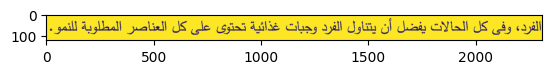

In [82]:
plt.imshow(preprocessed_book_pages[3][1])

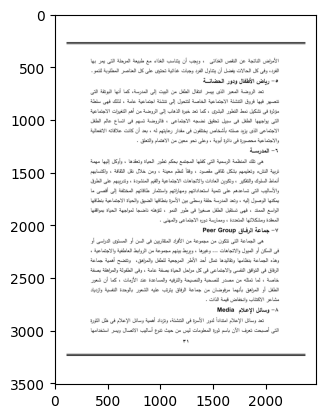

In [83]:
plt.imshow(pages[3])